# General linear model and F tests

See also: https://bic-berkeley.github.io/psych-214-fall-2016/hypothesis_tests.html

In [1]:
# Import numerical and plotting libraries
import numpy as np
import numpy.linalg as npl
import matplotlib.pyplot as plt
# Only show 6 decimals when printing
np.set_printoptions(precision=6)

In [2]:
%matplotlib inline

These two lists of numbers are from the GLM intro notebook:

In [3]:
psychopathy = [11.416,   4.514,  12.204,  14.835,
                8.416,   6.563,  17.343, 13.02,
               15.19 ,  11.902,  22.721,  22.324]

In [4]:
clammy = [0.389,  0.2  ,  0.241,  0.463,
          4.585,  1.097,  1.642,  4.972,
          7.957,  5.585,  5.527,  6.964]

Let's first check what R gives us for this simple regression model (you will need R installed for this):

```
# This is code to copy-paste into R
psychopathy <- c(11.416,   4.514,  12.204,  14.835, 8.416,   6.563,  17.343,
                13.02, 15.19 ,  11.902,  22.721,  22.324)
clammy = c(0.389,  0.2  ,  0.241,  0.463, 4.585,  1.097,  1.642,  4.972,
           7.957,  5.585,  5.527,  6.964)

simple_regression = lm(psychopathy ~ clammy)
print(summary(simple_regression))
```

Here are the utilities to show the design matrix graphically, from the GLM intro:

In [5]:
def scale_design_mtx(X):
    """utility to scale the design matrix for display

    This scales the columns to their own range so we can see the variations
    across the column for all the columns, regardless of the scaling of the
    column.
    """
    mi, ma = X.min(axis=0), X.max(axis=0)
    # Vector that is True for columns where values are not
    # all almost equal to each other
    col_neq = (ma - mi) > 1.e-8
    Xs = np.ones_like(X)
    # Leave columns with same value throughout with 1s
    # Scale other columns to min, max in column
    mi = mi[col_neq]
    ma = ma[col_neq]
    Xs[:,col_neq] = (X[:,col_neq] - mi)/(ma - mi)
    return Xs

In [6]:
def show_design(X, design_title):
    """ Show the design matrix nicely """
    plt.imshow(scale_design_mtx(X),
               interpolation='nearest',
               cmap='gray') # Gray colormap
    plt.title(design_title)

Remember, the first four students were from Berkeley, the second group of four were from Stanford, and the third group were from MIT.

$$
\newcommand{Xmat}{\boldsymbol X}
$$
The F test needs a *full model* and a *reduced model*.  Call the full model $\Xmat_f$ and the reduced model $\Xmat_r$.  The formula for the F test is:

$$
F_{\nu_1, \nu_2} =
    \frac{
    (\textrm{SSR}(\Xmat_r) - \textrm{SSR}(\Xmat_f)) / \nu_1}
    {\textrm{SSR}(\Xmat_f) / \nu_2}
$$

where $\nu_1$ is called the *numerator degrees of freedom*, and $\nu_2$ is the *denominator degrees of freedom* or the *degrees of freedom of the error*.

$\nu_2$ is also the degrees of freedom for the full model.  $\nu_1$ is given by $d - \nu_2$ where $d$ is the degrees of freedom from the reduced model.

First, let's see what R does:

```
# R script for one-way ANOVA F test
psychopathy <- c(11.416,   4.514,  12.204,  14.835, 8.416,   6.563,  17.343,
                13.02, 15.19 ,  11.902,  22.721,  22.324)

university <- factor(c(rep('Berkeley', 4),
                       rep('Stanford', 4),
                       rep('MIT', 4)))

one_way_anova = lm(psychopathy ~ university)
print(summary(one_way_anova))
```

And now, an F test, the traditional way.

This is the standard F test you may be used to, for a one-way analysis of variance.

The reduced model is a model that just has the mean for all the observations, independent of group (university).

The full model allows each group (university) to have its own mean.  The F test looks at the reduction in variance when we include the group means into the model.

In [7]:
overall_mean = np.mean(psychopathy)
overall_mean

13.370666666666667

In [8]:
overall_mean_corrected = psychopathy - overall_mean
overall_mean_corrected

array([-1.954667, -8.856667, -1.166667,  1.464333, -4.954667, -6.807667,
        3.972333, -0.350667,  1.819333, -1.468667,  9.350333,  8.953333])

In [9]:
# What do you think this will be?
# np.mean(overall_mean_corrected)

In [10]:
berkeley_mean = np.mean(psychopathy[:4])
stanford_mean = np.mean(psychopathy[4:8])
mit_mean = np.mean(psychopathy[8:])
berkeley_mean, stanford_mean, mit_mean

(10.74225, 11.3355, 18.03425)

In [11]:
# Subtract the matching group mean from each row
group_mean_corrected = np.array(psychopathy).copy()
group_mean_corrected[:4] = group_mean_corrected[:4] - berkeley_mean
group_mean_corrected[4:8] = group_mean_corrected[4:8] - stanford_mean
group_mean_corrected[8:] = group_mean_corrected[8:] - mit_mean
group_mean_corrected

array([ 0.67375, -6.22825,  1.46175,  4.09275, -2.9195 , -4.7725 ,
        6.0075 ,  1.6845 , -2.84425, -6.13225,  4.68675,  4.28975])

In [12]:
SSR_full = np.sum(group_mean_corrected ** 2)
SSR_reduced = np.sum(overall_mean_corrected ** 2)
SSR_full, SSR_reduced

(214.42201450000005, 345.61996266666671)

In [13]:
N = len(psychopathy)
df_error = N - 3
df_extra = 3 - 1
F_top = (SSR_reduced - SSR_full) / df_extra
F_bottom = SSR_full / df_error
F_stat = F_top / F_bottom
F_stat

2.75340555925054

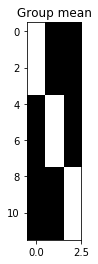

In [14]:
# Back to the old model
X_full = np.zeros((N, 3))
X_full[:4, 0] = 1  # Berkeley indicator is first column
X_full[4:8, 1] = 1  # Stanford indicator is second column
X_full[8:, 2] = 1  # MIT indicator is third column
show_design(X_full, 'Group mean')

In [15]:
B_full = npl.pinv(X_full).dot(psychopathy)
B_full

array([ 10.74225,  11.3355 ,  18.03425])

In [16]:
full_fitted = X_full.dot(B_full)
full_residuals = psychopathy - full_fitted
full_residuals

array([ 0.67375, -6.22825,  1.46175,  4.09275, -2.9195 , -4.7725 ,
        6.0075 ,  1.6845 , -2.84425, -6.13225,  4.68675,  4.28975])

In [17]:
# The reduced design - the overall mean
X_reduced = np.ones((N, 1))
X_reduced

array([[ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.]])

In [18]:
B_reduced = npl.pinv(X_reduced).dot(psychopathy)
B_reduced

array([ 13.370667])

In [19]:
reduced_fitted = X_reduced.dot(B_reduced)
reduced_residuals = psychopathy - reduced_fitted
reduced_residuals

array([-1.954667, -8.856667, -1.166667,  1.464333, -4.954667, -6.807667,
        3.972333, -0.350667,  1.819333, -1.468667,  9.350333,  8.953333])

In [20]:
GLM_SSR_full = np.sum(full_residuals ** 2)
GLM_SSR_reduced = np.sum(reduced_residuals ** 2)
GLM_SSR_full, GLM_SSR_reduced

(214.42201450000005, 345.61996266666665)

OK - now the same thing with the original clammy model:

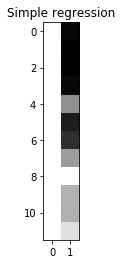

In [21]:
X_regression_full = np.column_stack((np.ones(12), clammy))
show_design(X_regression_full, 'Simple regression')

In [22]:
B_regression_full = npl.pinv(X_regression_full).dot(psychopathy)
B_regression_full

array([ 10.071286,   0.999257])

In [23]:
fitted_regression_full = X_regression_full.dot(B_regression_full)
residuals_regression_full = psychopathy - fitted_regression_full
residuals_regression_full

array([ 0.956003, -5.757137,  1.891893,  4.301058, -6.23688 , -4.604471,
        5.630934, -2.019593, -2.832376, -3.750137,  7.126819,  5.293887])

In [24]:
SSR_regression_full = np.sum(residuals_regression_full ** 2)
F_top = (SSR_reduced - SSR_regression_full) / 1
F_bottom = SSR_regression_full / (N - 2)
F_stat = F_top / F_bottom
F_stat

3.664886189966519